In [ ]:
import sys, os
sys.path.append("../main")
from santa_fe_2 import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import njit
from scipy.optimize import curve_fit
import pandas as pd
import statsmodels.api as sm
import scipy.stats


@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    for i in range(1,max_lag,step):
        impact.append((-sign[:-i]*(price[i:]-price[:-i])).mean())
    
    return impact

@njit()
def compute_diffusion_rate(vol_size,array, min_val = 1):
    variance = np.zeros(vol_size - min_val + 1)
    for i in range(min_val, vol_size+1):
        variance[i - min_val] = (array[i:]-array[:-i]).var()
        
    return variance

@njit()
def compute_signature_plot(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        new_arr = array[::i]
        square_sum = (new_arr[1:] - new_arr[:-1])**2
        sigma[i-1] = square_sum.sum()
        
    return np.sqrt(sigma)

def avg(lst):
    return np.array(lst).mean()

def func(x, m, q):
    return m * x + q

def find_param(xx,yy):
    popt, pcov = curve_fit(func, xx, yy)
    m = popt[0]
    q = popt[1]
    err_m = np.sqrt(pcov[0][0])
    err_q = np.sqrt(pcov[1][1])

    
    return m, q, err_m, err_q

def func(x,x0,gamma):
    return x0*x+gamma

def func2(x,x0,gamma):
    return x0*x**gamma

def find_param_vol(xx,yy,x0=10e-5,gamma=1):
    popt, pcov = curve_fit(func2, xx, yy,p0=(x0,gamma))
    xx0 = popt[0]
    gamma0 = popt[1]
    return xx0,gamma0

@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    std_impact = []
    for i in range(1,max_lag,step):
        impact.append((sign[:-i]*(price[i:]-price[:-i])).mean())
        std_impact.append((sign[:-i]*(price[i:]-price[:-i])).std() / np.sqrt(len(price[i:])))
    
    return impact, std_impact
    
plt.style.use('dark_background')

# Lob Small tick stock

Per prezzi lontani dal mid price il LOB raggiunge uno stato stazionario, il livello di occupazione per un prezzo segue la distribuzione:

$e^{-V^{\star}}\frac{(V^{\star})^V}{V!}, \quad \quad V^{\star} = \lambda/\delta $

In particolare ci aspettiamo quindi che per una small tick stock la forma del LOB sia sparsa, mentre ci aspettiamo che sia densa per big tick stock.

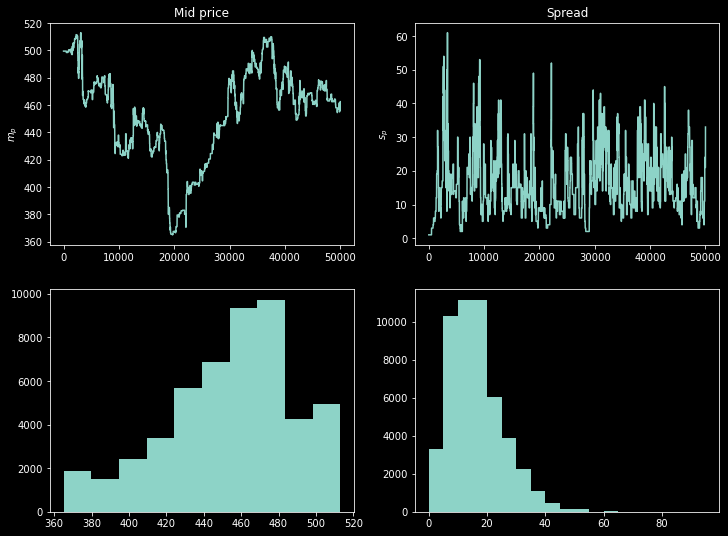

15.74784


In [2]:
rate_lim = 0.018 
rate_m   = 0.055 
rate_del = 0.107



lob, order, typ, pric  = simulate_lob(rate_lim, rate_m, rate_del,1000,50_000)

md, sp = find_mid_spread_lob(lob)

fig,ax = plt.subplots(2,2,figsize = (12,9))

ax[0,0].plot(md)
ax[0,0].set_ylabel(r"$m_p$")
ax[0,0].set_title("Mid price")
ax[1,0].hist(md)
ax[0,1].plot(sp)
ax[0,1].set_ylabel(r"$s_p$")
ax[0,1].set_title("Spread")
ax[1,1].hist(sp,bins=np.arange(0,100,5))

plt.show()
print(sp.mean())

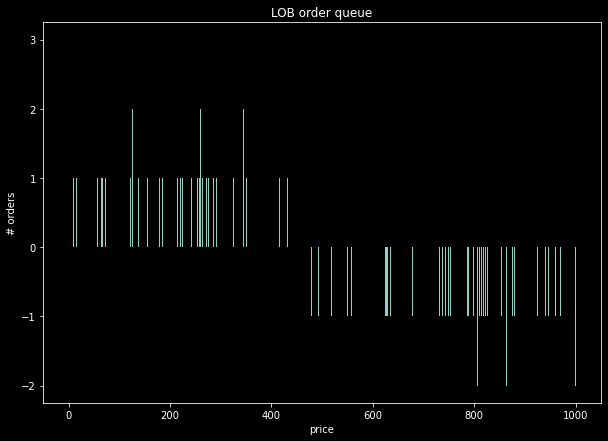

In [3]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.bar(np.arange(1000),lob[-1])
plt.title("LOB order queue")
plt.ylabel("# orders")
plt.xlabel("price")
plt.show()

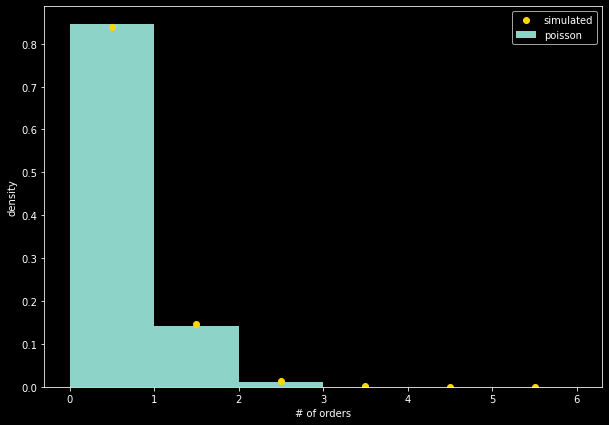

In [4]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
ps = scipy.stats.poisson.rvs(rate_lim/rate_del, size=1000000)
plt.hist(ps,density = True, bins=np.arange(0,7), label="poisson")
n, n_bins, _ = plt.hist(np.abs(lob[-1]), density = True, bins=np.arange(0,7), alpha = 0)
real_b = (n_bins[1:] + n_bins[:-1]) / 2
plt.plot(real_b, n, "o", label="simulated", c = "gold")
plt.xlabel("# of orders")
plt.ylabel("density")
plt.legend()
plt.show()

# Lob large tick stock

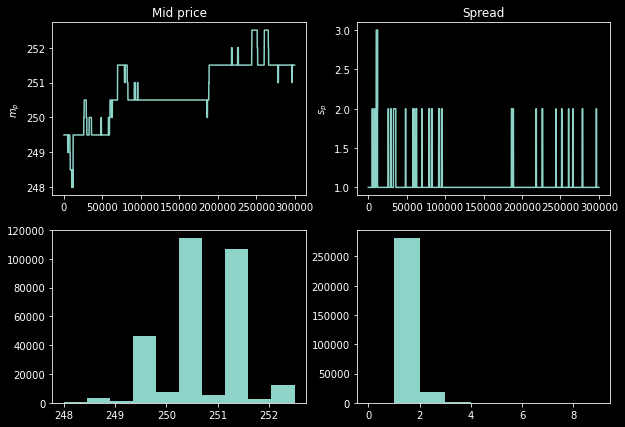

1.0665966666666666


In [20]:
rate_lim = 0.169
rate_m   = 0.031
rate_del = 0.041



lob, order, typ, pric  = simulate_lob(rate_lim, rate_m, rate_del,500,300_000)

md, sp = find_mid_spread_lob(lob)

fig,ax = plt.subplots(2,2,figsize = (10,7))

ax[0,0].plot(md)
ax[0,0].set_ylabel(r"$m_p$")
ax[0,0].set_title("Mid price")
ax[1,0].hist(md)
ax[0,1].plot(sp)
ax[0,1].set_ylabel(r"$s_p$")
ax[0,1].set_title("Spread")
ax[1,1].hist(sp,bins=np.arange(0,10))

plt.show()
print(sp.mean())

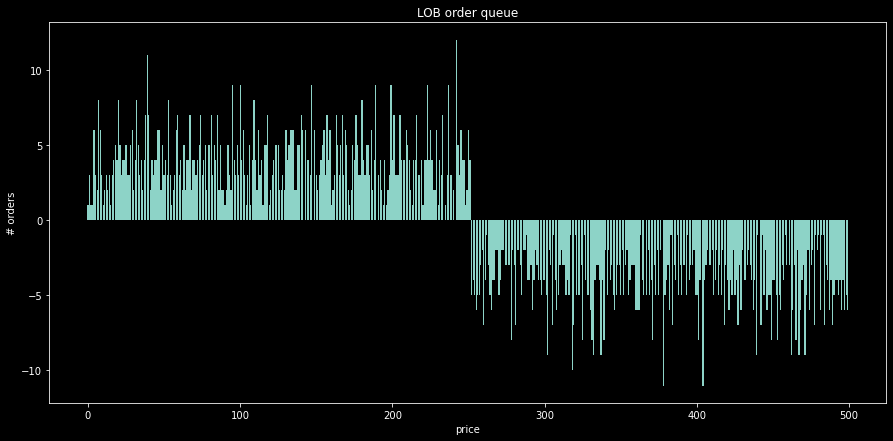

In [21]:
fig,ax = plt.subplots(1,1,figsize = (15,7))
plt.bar(np.arange(500),lob[-1])
plt.title("LOB order queue")
plt.ylabel("# orders")
plt.xlabel("price")
plt.show()

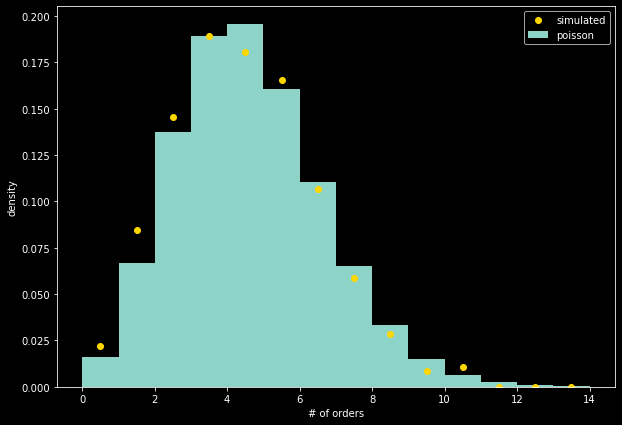

In [7]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
ps = scipy.stats.poisson.rvs(rate_lim/rate_del, size=1000000)
n_p, bins_p, _ = plt.hist(ps, density = True, bins=np.arange(0,15), alpha = 1, label="poisson")

lob_buy = np.abs(lob[-1,:230])
lob_sell = np.abs(lob[-1,270:])
lob_far = np.concatenate((lob_buy, lob_sell), axis=None)
n, n_bins, _ = plt.hist(lob_far, density = True, bins=np.arange(0,15), alpha = 0)
real_b = (n_bins[1:] + n_bins[:-1]) / 2
plt.plot(real_b, n, "o", label="simulated", c = "gold")

plt.xlabel("# of orders")
plt.ylabel("density")
plt.legend()
plt.show()

In [8]:
chi_2 = ((n - n_p)**2 / n_p * 460).sum()
print(f"chi 2 = {chi_2:.3f}, degree of freedom = 13")

chi 2 = 8.985, degree of freedom = 13


# Mid spread

Abbiamo che esiste una relazione di scaling che lega $\lambda$ , $\mu$ , $\nu$ allo spread medio.

Infatti abbiamo che:
$<s> = \frac{\mu}{\lambda} F(\frac{\delta}{\mu}) $

con F(u) che vale:

$F(u) \sim 0.28 + 1.86 u^{3/4}$

Voglio verificare adesso questa relazione di scaling

In [9]:
mean_sp = np.zeros(15)
std_sp  = np.zeros(15)
rates = np.linspace(1, 5 ,15)

monte_sp = np.zeros(8)

for k in range(15):
    print(k, end= "\r")
    
    rate_lim = 1/rates[k]
    rate_m   = 1
    rate_del = 0
    
    for i in range(8):
        lob, order, typ, pric = simulate_lob(rate_lim, rate_m, rate_del, 400 ,300_000)
        md, sp = find_mid_spread_lob(lob)
        
        monte_sp[i] = sp.mean()
        
    mean_sp[k] = monte_sp.mean()

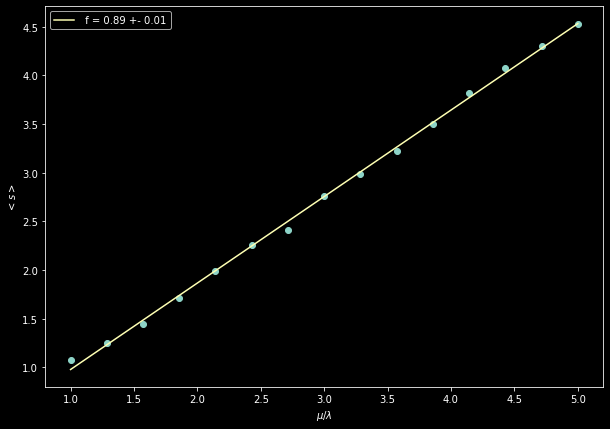

In [10]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.errorbar(x = rates, y = mean_sp, ls="", marker="o",zorder=2)
m,q,dm,dq = find_param(rates, mean_sp)

plt.plot(rates,func(rates,m,q), zorder= 3, label = f" f = {m:.2f} +- {dm:.2f}")
plt.xlabel(r"$\mu/\lambda$")
plt.ylabel(r"$<s>$")
plt.legend()
plt.show()

# volatility

In [11]:
rate_lim = 1
rate_m   = 1
rate_del = 1
    
lob, order, typ, pric = simulate_lob(rate_lim, rate_m, rate_del, 200, 1_000_000)
md, sp = find_mid_spread_lob(lob)
  
m1 = np.log(md)


rate_lim = 1
rate_m   = 1
rate_del = 0.01
    
lob, order, typ, pric = simulate_lob(rate_lim, rate_m, rate_del, 200, 1_000_000)
md, sp = find_mid_spread_lob(lob)
  
m2 = np.log(md)


rate_lim = 1
rate_m   = 0.1
rate_del = 0.1
    
lob, order, typ, pric = simulate_lob(rate_lim, rate_m, rate_del, 200, 1_000_000)
md, sp = find_mid_spread_lob(lob)
  
m3 = np.log(md)

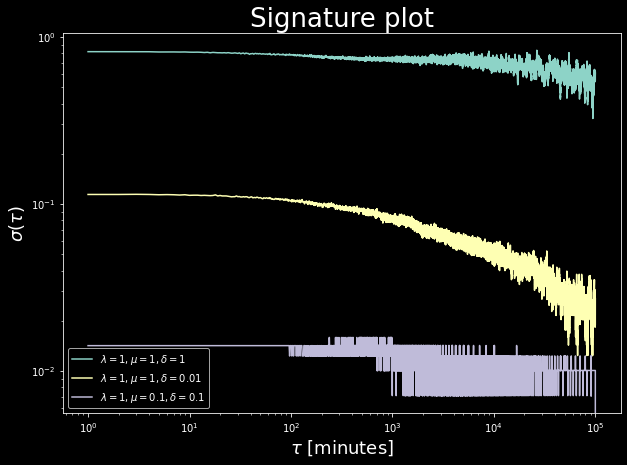

In [12]:
fig,ax = plt.subplots(1,1,figsize = (10,7))

v1 = compute_signature_plot(100_000,m1)
v2 = compute_signature_plot(100_000,m2)
v3 = compute_signature_plot(100_000,m3)

x = np.arange(1,100_001)
plt.plot(x, v1, label=r"$\lambda = 1, \mu = 1, \delta = 1$")
plt.plot(x, v2, label=r"$\lambda = 1, \mu = 1, \delta = 0.01$")
plt.plot(x, v3, label=r"$\lambda = 1, \mu = 0.1, \delta = 0.1$")

plt.loglog()
plt.xlabel(r"$\tau$ [minutes]",fontsize=18)
plt.ylabel(r"$\sigma(\tau)$",fontsize=18)
plt.title("Signature plot",fontsize=26)
plt.legend()
plt.show()